In [1]:
import glob
import os
import numpy as np
from PIL import Image
from tqdm.auto import tqdm

from monai.transforms import Resize, EnsureChannelFirst, LoadImage, Compose, ScaleIntensity
from monai.data import ArrayDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


C:\Users\michi\Documents\Uni\_Master\_Thesis\project\venv\lib\site-packages\ignite\handlers\checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [2]:
transformer = Compose([LoadImage(image_only=True),
                       EnsureChannelFirst(),
                       ScaleIntensity()])

image_path = "data_chaksu_polar/CHAKSU/Images/"
dm_path = "data_chaksu_polar/CHAKSU/Disc_Masks/"

data = ArrayDataset(img=sorted([image_path + file for file in os.listdir(image_path)]),
                          img_transform=transformer,
                          seg=sorted([dm_path + file for file in os.listdir(dm_path)]),
                          seg_transform=transformer)

dataloader = DataLoader(data,
                              batch_size=1,
                              shuffle=False,
                              num_workers=2)

0it [00:00, ?it/s]

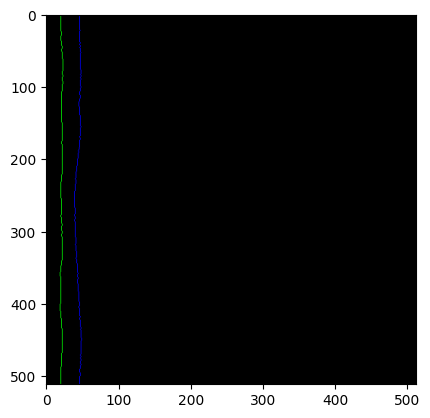

In [4]:
new_path = "data_chaksu_topunet/CHAKSU/"
old_path = "data_chaksu_polar/CHAKSU/"
names = sorted(os.listdir(old_path + "Images/"))

if not os.path.exists(new_path + "q_Masks"):
    os.makedirs(new_path + "q_Masks")
    
if not os.path.exists(new_path + "s_Masks"):
    os.makedirs(new_path + "s_Masks")


for j, batch in tqdm(enumerate(dataloader)):
    mask = (np.array(255*batch[1][0].permute(2, 1, 0)).astype(np.uint8) > 127).astype(np.uint8)
    diff = np.diff(mask, axis=1)
    mask[:, :, 2] = mask[:, :, 2] - mask[:, :, 1]
    
    new_image = Image.fromarray(mask*255)
    new_image.save(new_path + "Disc_Masks/" + names[j])
    diff[:, :, 0] = 0

    indices_cup = np.argmax(diff[:, :, 1], axis=1)
    indices_disc = np.argmax(diff[:, :, 2], axis=1)
    output = np.vstack([indices_cup, indices_disc])
    np.save(new_path + "s_Masks/" + names[j][:-3] + "npy", output)

    q_image = np.zeros(shape=mask.shape).astype(np.uint8)
    q_image[range(0, mask.shape[0]), list(indices_cup), 1] = 255
    q_image[range(0, mask.shape[0]), list(indices_disc), 2] = 255
    q_image = Image.fromarray(q_image)
    plt.imshow(q_image)
    q_image.save(new_path + "q_Masks/" + names[j])
    